In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from scipy import ndimage, signal
import math


%matplotlib inline


image_bank = {}

In [2]:
def get_image(filename='img/test_image2.png'):
    if filename in image_bank.keys():
        return image_bank[filename]
    
    img = cv2.imread(filename)
    image_bank[filename] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return image_bank[filename]


 
def plot_image(images, title=None, labels=None, size=(13, 4)):
    if not isinstance(images, list):
        images = [images]
 
    if not isinstance(labels, list):
        labels = []
 
    fig, axs = plt.subplots(1, len(images), figsize=size,  dpi=150)
 
    if title is not None:
        fig.suptitle(title, fontsize=16)
    need_titles = len(labels) == len(images)
    for i, image in enumerate(images):
        ax = axs[i] if len(images) > 1 else axs
 
        if need_titles:
            ax.set_title(labels[i])
        ax.imshow(image, cmap='gray')
        ax.axis('off')

        
def fft(img):
    return np.fft.fft2(img)


def shift(img):
    return np.fft.fftshift(img)


def log_norm(img):
    return np.power(np.abs(img), 0.1)
    
    


def return_to_image(f):
    return reverse(np.abs(fft(f)))


def reverse(image):
    return image[::-1, ::-1]


def ideal_filter_kernel(image_size, inner_field):
    center = image_size[0] // 2, image_size[1] // 2
    inner_size = inner_field.shape
    left = center[0] - inner_size[0] // 2, center[1] - inner_size[1] // 2
    
#     print(center)
#     print(inner_size)
#     print(left)
    
    kernel = np.zeros(image_size)
    kernel[left[0]:left[0]+inner_size[0], left[1]:left[1]+inner_size[1]] = inner_field
    return kernel
    
    
def ellipse(size):
    return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, size)

original image size = (528, 546)


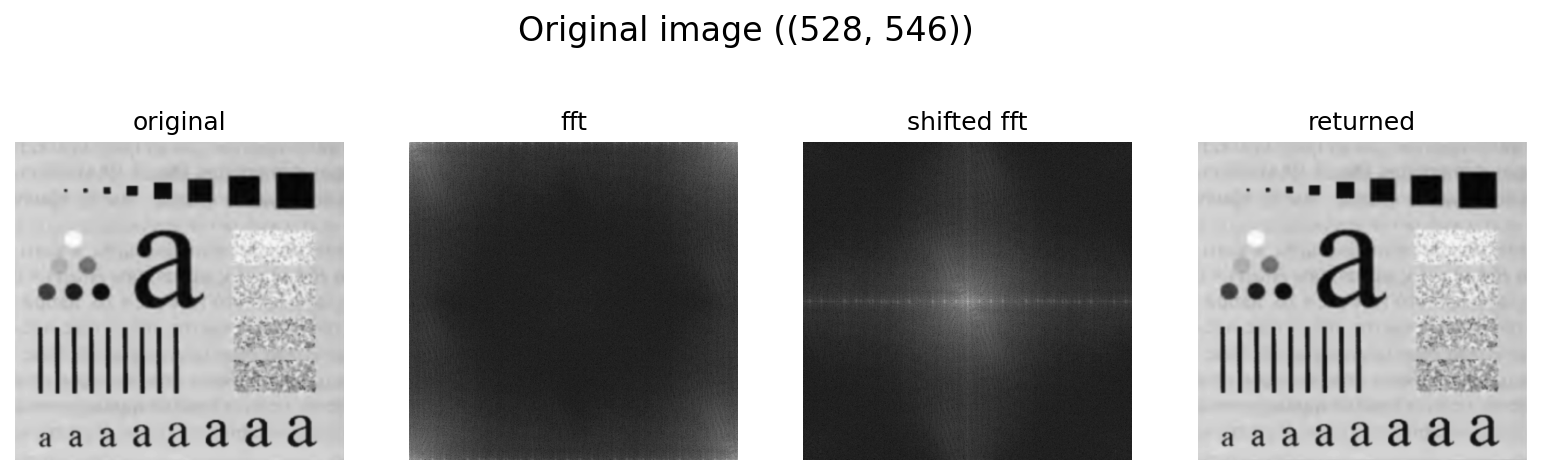

In [3]:
def show_original():
    f = fft(get_image())
    print(f'original image size = {get_image().shape}')
    normed = log_norm(f)
    shifted = shift(f)
    plot_image([get_image(), normed, log_norm(shifted), reverse(np.abs(fft(f)))],
              labels=[ 'original', 'fft', 'shifted fft', 'returned' ],
              title=f'Original image ({f.shape})')
    
    
show_original()

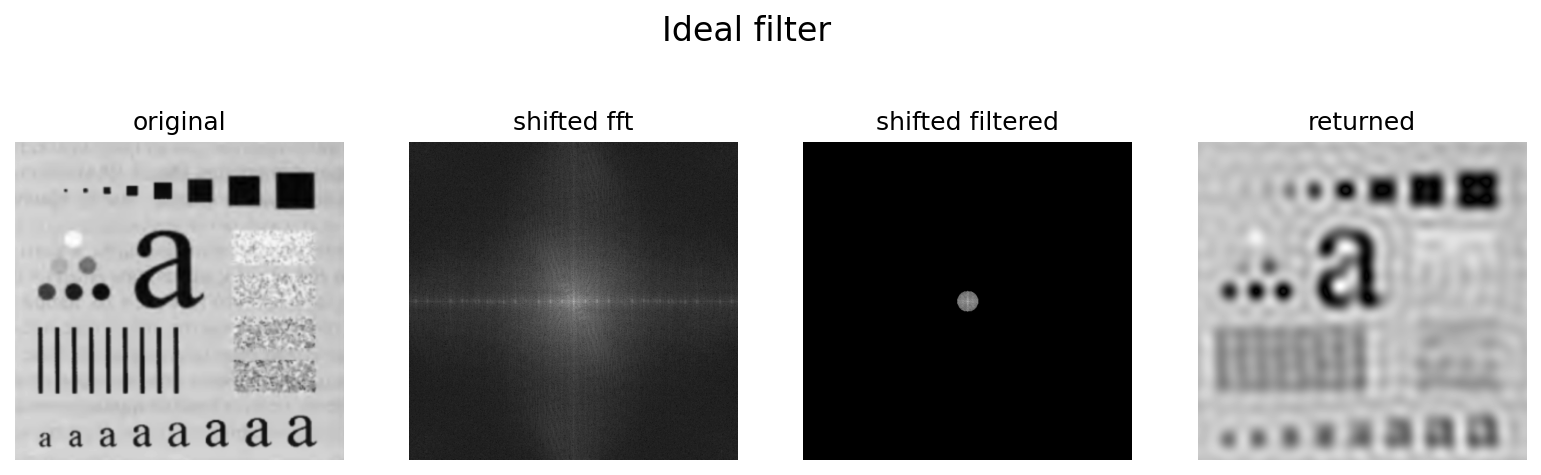

In [4]:
def apply_filter(image, kernel, title=""):
    f = fft(image) 
    shifted = shift(f)
    filtered = 1 - shifted * kernel
    plot_image([image, log_norm(shifted), log_norm(filtered), reverse(np.abs(fft(filtered)))],
              labels=[ 'original', 'shifted fft', 'shifted filtered', 'returned' ],
              title=title)


apply_filter(get_image(), ideal_filter_kernel(get_image().shape, ellipse((35, 35))), "Ideal filter")

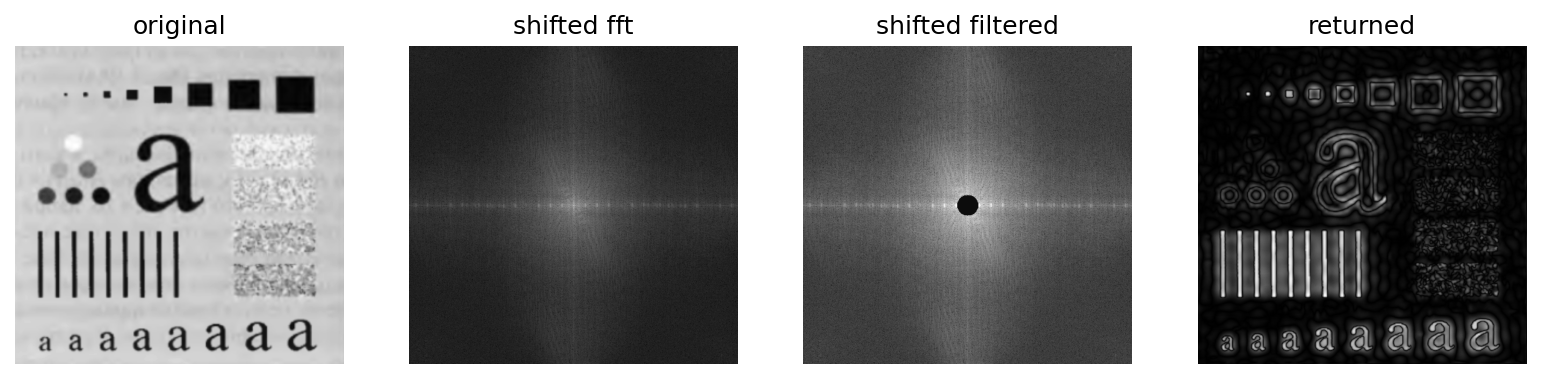

In [5]:
apply_filter(get_image(), 1 - ideal_filter_kernel(get_image().shape, ellipse((35, 35))))

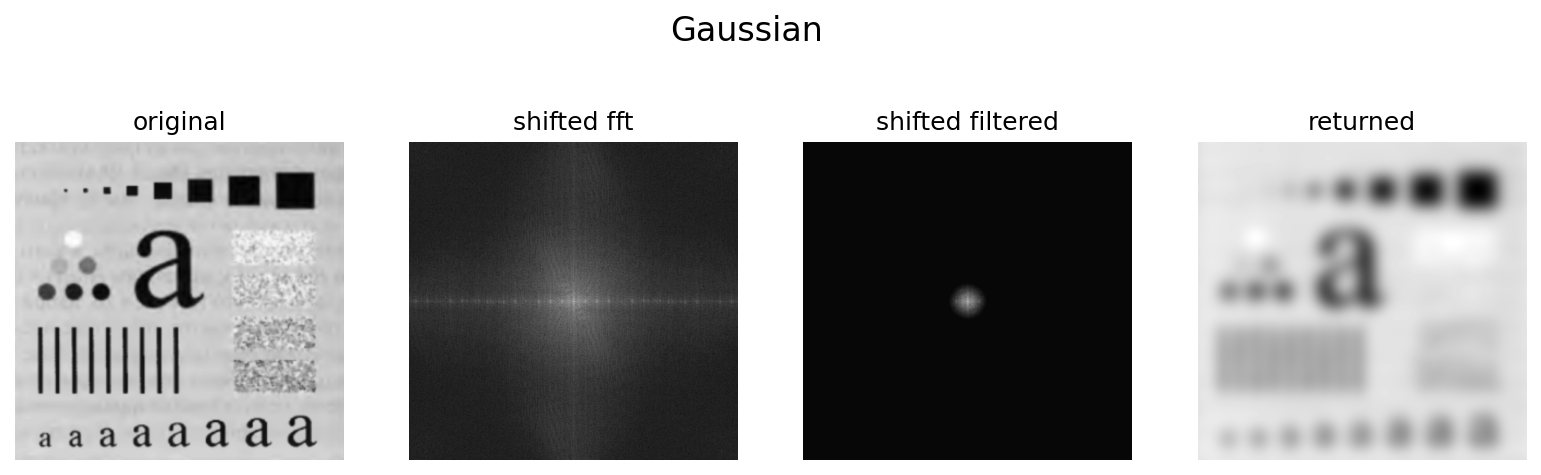

In [6]:
def gaussian_lpf():
    original = get_image()
    f = fft(original)
    gaussian = 1 - ndimage.fourier_gaussian(f, sigma=13)
    filtered = reverse(np.abs(fft(gaussian)))
    plot_image([original, log_norm(shift(f)), log_norm(shift(gaussian)), filtered],
              labels=[ 'original', 'shifted fft', 'shifted filtered', 'returned' ],
              title="Gaussian")

    
def gaussian_hpf():
    original = get_image()
    f = fft(original)
    gaussian = f - ndimage.fourier_gaussian(f, sigma=5)
    filtered = reverse(np.abs(fft(gaussian)))
    plot_image([original, log_norm(shift(f)), log_norm(shift(gaussian)), filtered],
              labels=[ 'original', 'shifted fft', 'shifted filtered', 'returned' ])


gaussian_lpf()

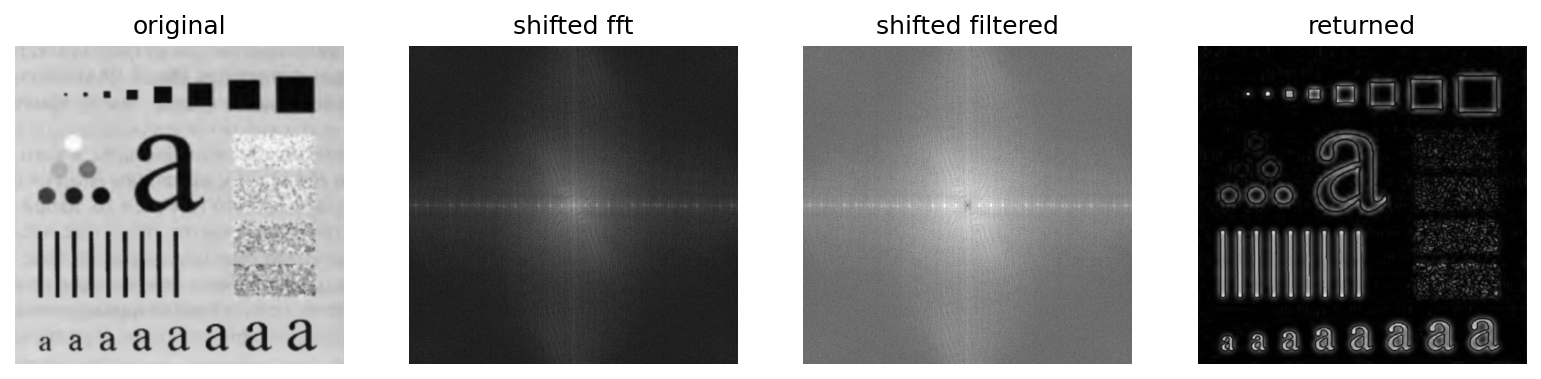

In [7]:
gaussian_hpf()

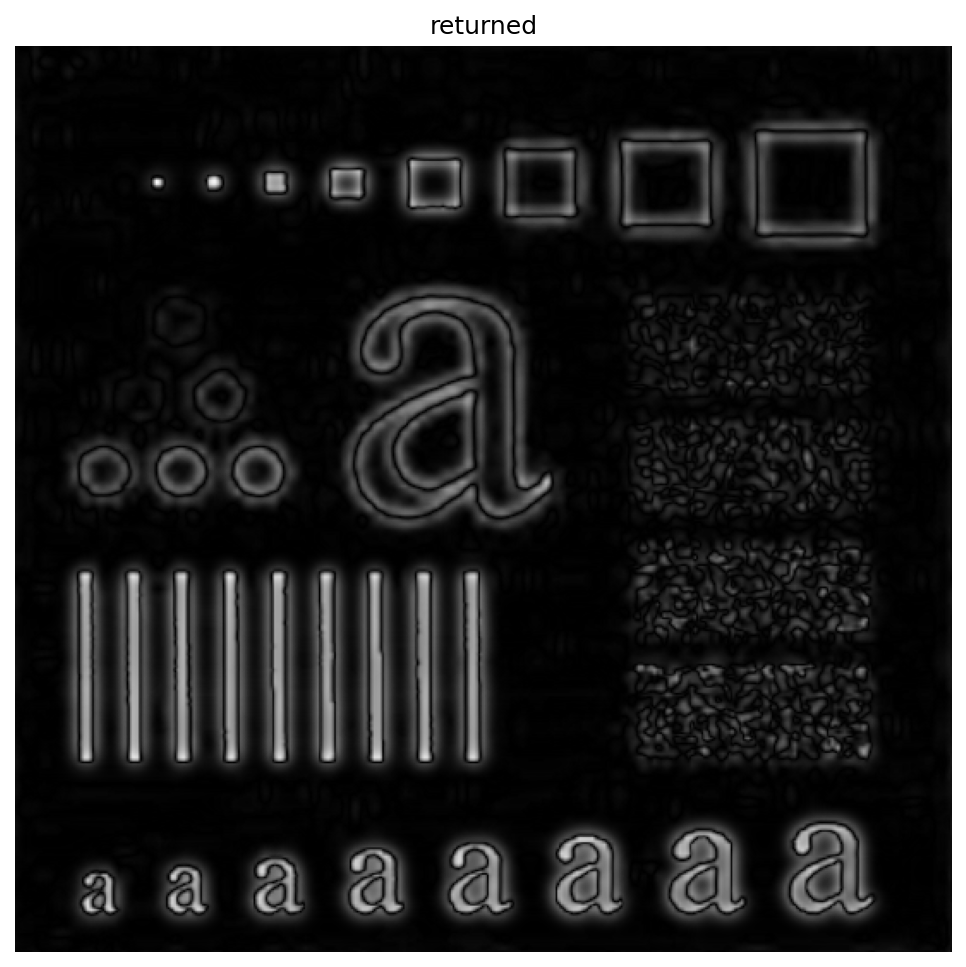

In [8]:
def gaussian_hpf_only_result():
    original = get_image()
    f = fft(original)
    gaussian = f - ndimage.fourier_gaussian(f, sigma=5)
    filtered = reverse(np.abs(fft(gaussian)))
    plot_image(filtered, labels=[ 'returned' ], size=(16, 8))
    
gaussian_hpf_only_result()

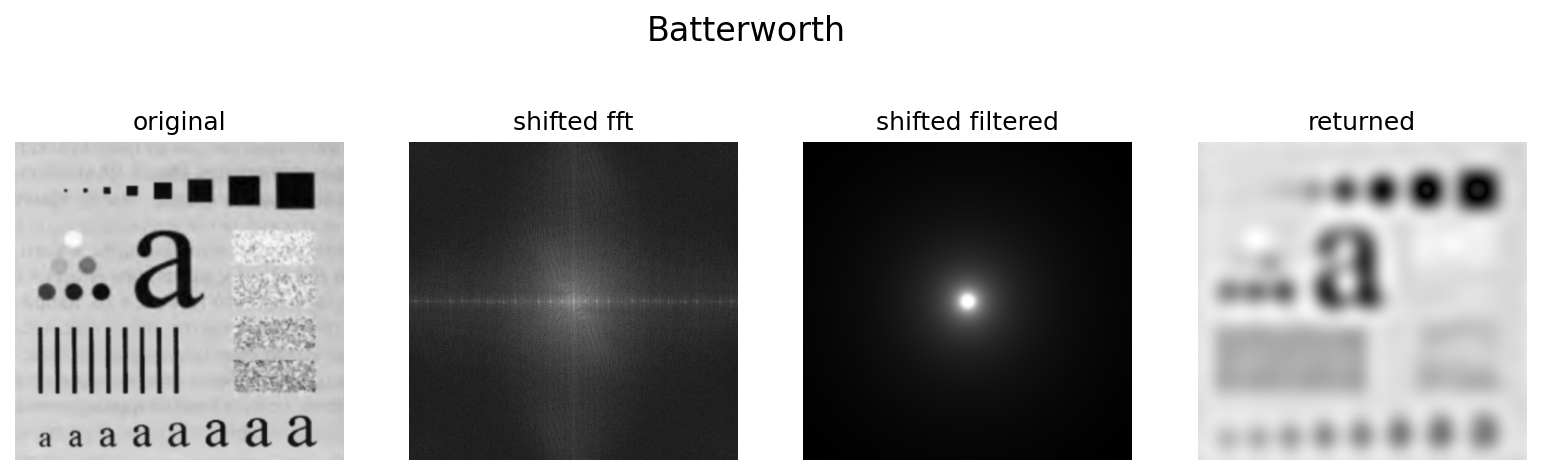

In [9]:
def distance(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)


def butterworth_kernel(image, d0, n):
    center = image.shape[0] // 2, image.shape[1] // 2
    size = image.shape
    kernel = np.zeros(image.shape)
    for x in range(size[0]):
        for y in range(size[1]):
            kernel[x][y] = 1 / (1 + (distance((x, y), center) / d0) ** (2**n))
    return kernel
    

def butterworth_lpf():
    original = get_image()
    f = fft(original)
    batterworth = shift(butterworth_kernel(f, 10, 3))
    filtered = reverse(np.abs(fft(batterworth * f)))
    plot_image([original, log_norm(shift(f)), log_norm(shift(batterworth)), filtered],
              labels=[ 'original', 'shifted fft', 'shifted filtered', 'returned' ],
              title="Batterworth")

    
def butterworth_hpf():
    original = get_image()
    f = fft(original)
    batterworth = shift(1 - butterworth_kernel(f, 10, 3))
    batterworth[batterworth == 0] = min(batterworth[batterworth > 0])
    filtered = reverse(np.abs(fft(batterworth * f)))
    plot_image([original, log_norm(shift(f)), log_norm(shift(batterworth)), filtered],
              labels=[ 'original', 'shifted fft', 'shifted filtered', 'returned' ])


butterworth_lpf()

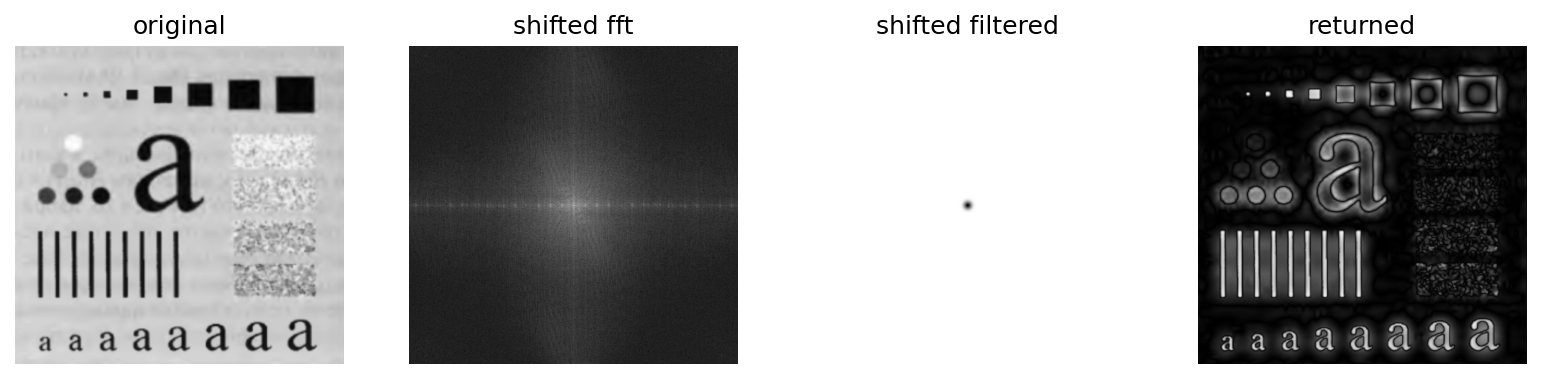

In [10]:
butterworth_hpf()